In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [7]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(111,)

In [8]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [9]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          86
Solid Tissue Normal    84
Name: Sample Type, dtype: int64

Primary Tumor          30
Solid Tissue Normal    27
Name: Sample Type, dtype: int64

In [11]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = train[target].cat.categories.values


Cuda is available: True


In [12]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [13]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (0): Linear(in_features=60483, out_features=2000, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=500, out_features=250, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=250, out_features=100, bias=True)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=100, out_features=50, bias=True)
      (9): PReLU(num_parameters=1)
      (10): Linear(in_features=50, out_features=10, bias=True)
      (11): PReLU(num_parameters=1)
      (12): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [14]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.237146
Epoch: 1/10. Train set: Average loss: 24.8524
Epoch: 1/10. Validation set: Average loss: 4.1286
Train: [0/170 (0%)]	Loss: 3.122349
Epoch: 2/10. Train set: Average loss: 51.4417
Epoch: 2/10. Validation set: Average loss: 18.8456
Train: [0/170 (0%)]	Loss: 24.674990
Epoch: 3/10. Train set: Average loss: 52.2205
Epoch: 3/10. Validation set: Average loss: 5.4529
Train: [0/170 (0%)]	Loss: 18.828060
Epoch: 4/10. Train set: Average loss: 16.1846
Epoch: 4/10. Validation set: Average loss: 1.9008
Train: [0/170 (0%)]	Loss: 1.131958
Epoch: 5/10. Train set: Average loss: 6.2124
Epoch: 5/10. Validation set: Average loss: 0.3215
Train: [0/170 (0%)]	Loss: 5.370792
Epoch: 6/10. Train set: Average loss: 1.0096
Epoch: 6/10. Validation set: Average loss: 0.6983
Train: [0/170 (0%)]	Loss: 0.806775
Epoch: 7/10. Train set: Average loss: 0.9206
Epoch: 7/10. Validation set: Average loss: 0.1207
Train: [0/170 (0%)]	Loss: 0.086260
Epoch: 8/10. Train set: Average loss: 0.1156
Epo

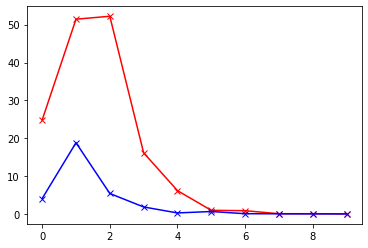

In [15]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

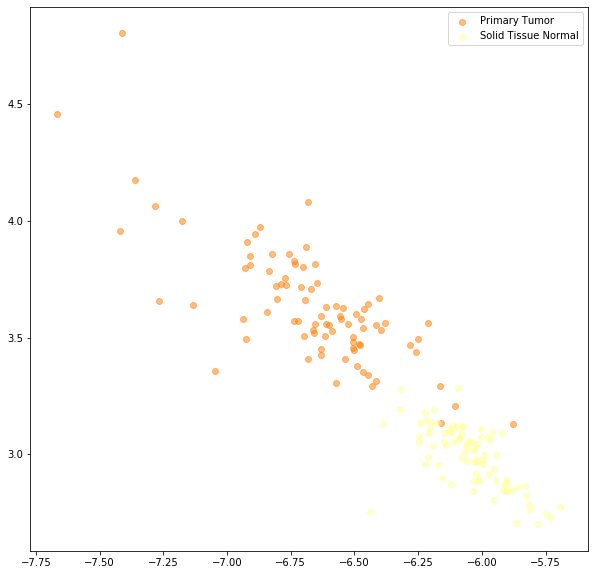

In [16]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

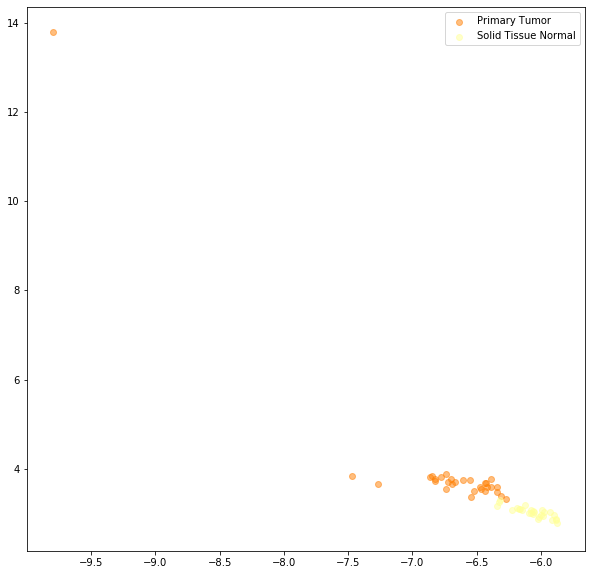

In [17]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

## Saliency
"the magnitude of the derivative indicates which pixels need to be changed the least to affect the class score the most"

In [18]:
saliency_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=1, shuffle=False, **kwargs)

In [19]:
def saliency_eval(val_loader, model, loss_fn, cuda):
    model.eval()
    val_loss = 0
    saliency_pairs = (torch.zeros(len(val_loader), 60483), torch.zeros(len(val_loader), 60483), torch.zeros(len(val_loader)))
    for batch_idx, (data, target) in enumerate(val_loader):
        model.zero_grad()
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
        # need to instantiate input with require_grad!
        data = (Variable(data[0], requires_grad=True), Variable(data[1], requires_grad=True))
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        saliency_pairs[0][batch_idx] = data[0].grad
        saliency_pairs[1][batch_idx] = data[1].grad
        saliency_pairs[2][batch_idx] = loss.item()
        val_loss += loss.item()

    return val_loss, saliency_pairs


In [20]:
val_loss, saliency_pairs = saliency_eval(saliency_loader, model, loss_fn, cuda)

In [21]:
test_pairs = np.array(siamese_test_dataset.test_pairs)

In [ ]:
sli

In [23]:
ex1 = pd.DataFrame(saliency_pairs[0].numpy(), columns=test_dataset.data.columns, index=test_pairs[:,0])
ex2 = pd.DataFrame(saliency_pairs[1].numpy(), columns=test_dataset.data.columns, index=test_pairs[:,1])
ex1.head()
ex2.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000269475.2,ENSG00000201788.1,ENSG00000134108.11,ENSG00000263089.1,ENSG00000172137.17,ENSG00000167700.7,ENSG00000234943.2,ENSG00000240423.1,ENSG00000060642.9,ENSG00000271616.1,ENSG00000234881.1,ENSG00000236040.1,ENSG00000231105.1,ENSG00000243044.1,ENSG00000182141.8,ENSG00000269416.4,ENSG00000264981.1,ENSG00000275265.1,ENSG00000185105.4,ENSG00000233540.1,ENSG00000102174.8,ENSG00000271647.1,ENSG00000166391.13,ENSG00000270469.1,ENSG00000070087.12,ENSG00000262950.1,ENSG00000255420.1,ENSG00000280038.1,ENSG00000266261.1,ENSG00000153561.11,ENSG00000269148.1,ENSG00000274458.1,ENSG00000273406.1,ENSG00000179262.8,ENSG00000214198.6,ENSG00000278099.1,ENSG00000166368.2,ENSG00000206072.11,ENSG00000234900.1,ENSG00000258630.1,ENSG00000127511.8,ENSG00000220993.1,ENSG00000225269.2,ENSG00000214062.5,ENSG00000095587.8,ENSG00000274219.1,ENSG00000230100.1,ENSG00000064601.15,ENSG00000227766.1,ENSG00000008517.15,ENSG00000215246.5,ENSG00000266644.1,ENSG00000236893.1,ENSG00000254465.1,ENSG00000088179.7,ENSG00000070081.14,ENSG00000275479.1,ENSG00000166634.5,ENSG00000261789.1,ENSG00000254092.1,ENSG00000197421.8,ENSG00000161558.9,ENSG00000276644.3,ENSG00000260900.1,ENSG00000278732.1,ENSG00000196167.8,ENSG00000268465.1,ENSG00000264438.2,ENSG00000204113.6,ENSG00000207000.1,ENSG00000254131.1,ENSG00000118972.1,ENSG00000264104.1,ENSG00000179833.4,ENSG00000264576.1,ENSG00000064225.11,ENSG00000267108.1,ENSG00000221372.1,ENSGR0000264510.4,ENSG00000057294.12,ENSG00000227535.2,ENSG00000252628.2,ENSG00000166007.11,ENSG00000273055.1,ENSG00000242041.1,ENSG00000278923.1,ENSG00000167768.4,ENSG00000280159.1,ENSG00000235240.1,ENSG00000264172.1,ENSG00000199903.1,ENSG00000200058.1,ENSG00000275358.1,ENSG00000218358.2,ENSG00000266460.1,ENSG00000260371.1,ENSG00000264091.1,ENSG00000238921.2,ENSG00000274815.1,ENSG00000269349.1,ENSG00000200291.1,ENSG00000233614.6,ENSG00000022567.8,ENSG00000241670.3,ENSG00000278933.1,ENSG00000202175.1,ENSG00000120662.14,ENSG00000235523.1,ENSG00000249848.1,ENSG00000277826.1,ENSG00000230225.1,ENSG00000239877.2,ENSG00000201398.1,ENSG00000281474.1,ENSG00000272905.1,ENSG00000259952.1,ENSG00000260812.1,ENSG00000225630.1,ENSG00000230231.1,ENSG00000164283.11,ENSG00000231880.2,ENSG00000227489.1,ENSG00000254555.1,ENSG00000013392.7,ENSG00000258279.2,ENSG00000226688.5,ENSG00000250929.2,ENSG00000204581.2,ENSG00000225620.1,ENSG00000258477.1,ENSG00000225488.1,ENSG00000184178.14,ENSG00000237786.1,ENSG00000166913.11,ENSG00000275856.1,ENSG00000164112.11,ENSG00000259345.4,ENSG00000130204.11,ENSG00000280387.1,ENSG00000189099.10,ENSG00000232879.2,ENSG00000111863.11,ENSG00000164182.9,ENSG00000109618.10,ENSG00000271623.1,ENSG00000279345.1,ENSG00000214866.6,ENSG00000153015.14,ENSG00000202290.1,ENSG00000254578.1,ENSG00000240710.1,ENSG00000248778.1,ENSG00000250210.4,ENSG00000225215.1,ENSG00000257246.1,ENSG00000245017.2,ENSG00000281091.1,ENSG00000250885.1,ENSG00000273797.1,ENSG00000089116.3,ENSG00000036448.8,ENSG00000234055.1,ENSG00000267552.5,ENSG00000224695.1,ENSG00000106038.11,ENSG00000255189.1,ENSG00000164114.17,ENSG00000238698.1,ENSG00000199836.1,ENSG00000149089.11,ENSG00000251710.1,ENSG00000224570.1,ENSG00000179632.8,ENSG00000271677.1,ENSG00000114861.17,ENSG00000205030.1,ENSG00000138193.13,ENSG00000243073.3,ENSG00000152942.17,ENSG00000240809.1,ENSG00000280004.1,ENSG00000224560.3,ENSG00000227233.1,ENSG00000118363.10,ENSG00000258116.1,ENSG00000273311.1,ENSG00000136169.15,ENSG00000279700.1,ENSG00000121644.17,ENSG00000135903.17,ENSG00000138495.5,ENSG00000204528.3,ENSG00000169992.8,ENSG00000239344.1,ENSG00000253309.5,ENSG00000101323.4,ENSG00000272456.1,ENSG00000251538.4,ENSG00000263711.4,ENSG00000262662.1,ENSG00000127564.15,ENSG00000219395.2,ENSG00000255349.1,ENSG00000254843.1,ENSG00000277998.1,ENSG00000275248.1,ENSG00000226086.5,ENSG00000235023.1,ENSG00000176973.7,EN

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000269475.2,ENSG00000201788.1,ENSG00000134108.11,ENSG00000263089.1,ENSG00000172137.17,ENSG00000167700.7,ENSG00000234943.2,ENSG00000240423.1,ENSG00000060642.9,ENSG00000271616.1,ENSG00000234881.1,ENSG00000236040.1,ENSG00000231105.1,ENSG00000243044.1,ENSG00000182141.8,ENSG00000269416.4,ENSG00000264981.1,ENSG00000275265.1,ENSG00000185105.4,ENSG00000233540.1,ENSG00000102174.8,ENSG00000271647.1,ENSG00000166391.13,ENSG00000270469.1,ENSG00000070087.12,ENSG00000262950.1,ENSG00000255420.1,ENSG00000280038.1,ENSG00000266261.1,ENSG00000153561.11,ENSG00000269148.1,ENSG00000274458.1,ENSG00000273406.1,ENSG00000179262.8,ENSG00000214198.6,ENSG00000278099.1,ENSG00000166368.2,ENSG00000206072.11,ENSG00000234900.1,ENSG00000258630.1,ENSG00000127511.8,ENSG00000220993.1,ENSG00000225269.2,ENSG00000214062.5,ENSG00000095587.8,ENSG00000274219.1,ENSG00000230100.1,ENSG00000064601.15,ENSG00000227766.1,ENSG00000008517.15,ENSG00000215246.5,ENSG00000266644.1,ENSG00000236893.1,ENSG00000254465.1,ENSG00000088179.7,ENSG00000070081.14,ENSG00000275479.1,ENSG00000166634.5,ENSG00000261789.1,ENSG00000254092.1,ENSG00000197421.8,ENSG00000161558.9,ENSG00000276644.3,ENSG00000260900.1,ENSG00000278732.1,ENSG00000196167.8,ENSG00000268465.1,ENSG00000264438.2,ENSG00000204113.6,ENSG00000207000.1,ENSG00000254131.1,ENSG00000118972.1,ENSG00000264104.1,ENSG00000179833.4,ENSG00000264576.1,ENSG00000064225.11,ENSG00000267108.1,ENSG00000221372.1,ENSGR0000264510.4,ENSG00000057294.12,ENSG00000227535.2,ENSG00000252628.2,ENSG00000166007.11,ENSG00000273055.1,ENSG00000242041.1,ENSG00000278923.1,ENSG00000167768.4,ENSG00000280159.1,ENSG00000235240.1,ENSG00000264172.1,ENSG00000199903.1,ENSG00000200058.1,ENSG00000275358.1,ENSG00000218358.2,ENSG00000266460.1,ENSG00000260371.1,ENSG00000264091.1,ENSG00000238921.2,ENSG00000274815.1,ENSG00000269349.1,ENSG00000200291.1,ENSG00000233614.6,ENSG00000022567.8,ENSG00000241670.3,ENSG00000278933.1,ENSG00000202175.1,ENSG00000120662.14,ENSG00000235523.1,ENSG00000249848.1,ENSG00000277826.1,ENSG00000230225.1,ENSG00000239877.2,ENSG00000201398.1,ENSG00000281474.1,ENSG00000272905.1,ENSG00000259952.1,ENSG00000260812.1,ENSG00000225630.1,ENSG00000230231.1,ENSG00000164283.11,ENSG00000231880.2,ENSG00000227489.1,ENSG00000254555.1,ENSG00000013392.7,ENSG00000258279.2,ENSG00000226688.5,ENSG00000250929.2,ENSG00000204581.2,ENSG00000225620.1,ENSG00000258477.1,ENSG00000225488.1,ENSG00000184178.14,ENSG00000237786.1,ENSG00000166913.11,ENSG00000275856.1,ENSG00000164112.11,ENSG00000259345.4,ENSG00000130204.11,ENSG00000280387.1,ENSG00000189099.10,ENSG00000232879.2,ENSG00000111863.11,ENSG00000164182.9,ENSG00000109618.10,ENSG00000271623.1,ENSG00000279345.1,ENSG00000214866.6,ENSG00000153015.14,ENSG00000202290.1,ENSG00000254578.1,ENSG00000240710.1,ENSG00000248778.1,ENSG00000250210.4,ENSG00000225215.1,ENSG00000257246.1,ENSG00000245017.2,ENSG00000281091.1,ENSG00000250885.1,ENSG00000273797.1,ENSG00000089116.3,ENSG00000036448.8,ENSG00000234055.1,ENSG00000267552.5,ENSG00000224695.1,ENSG00000106038.11,ENSG00000255189.1,ENSG00000164114.17,ENSG00000238698.1,ENSG00000199836.1,ENSG00000149089.11,ENSG00000251710.1,ENSG00000224570.1,ENSG00000179632.8,ENSG00000271677.1,ENSG00000114861.17,ENSG00000205030.1,ENSG00000138193.13,ENSG00000243073.3,ENSG00000152942.17,ENSG00000240809.1,ENSG00000280004.1,ENSG00000224560.3,ENSG00000227233.1,ENSG00000118363.10,ENSG00000258116.1,ENSG00000273311.1,ENSG00000136169.15,ENSG00000279700.1,ENSG00000121644.17,ENSG00000135903.17,ENSG00000138495.5,ENSG00000204528.3,ENSG00000169992.8,ENSG00000239344.1,ENSG00000253309.5,ENSG00000101323.4,ENSG00000272456.1,ENSG00000251538.4,ENSG00000263711.4,ENSG00000262662.1,ENSG00000127564.15,ENSG00000219395.2,ENSG00000255349.1,ENSG00000254843.1,ENSG00000277998.1,ENSG00000275248.1,ENSG00000226086.5,ENSG00000235023.1,ENSG00000176973.7,EN

In [24]:
pos_ind = np.where(test_pairs[:,2]==1)[0]
neg_ind = np.where(test_pairs[:,2]==0)[0]

In [25]:
ex1.iloc[pos_ind].mean().nlargest(10)

0
ENSG00000207862.1    0.000001
ENSG00000252870.1    0.000001
ENSG00000254424.1    0.000001
ENSG00000254526.1    0.000001
ENSG00000266611.1    0.000001
ENSG00000216001.2    0.000001
ENSG00000249081.1    0.000001
ENSG00000227125.1    0.000001
ENSG00000252524.1    0.000001
ENSG00000230564.1    0.000001
dtype: float32

In [26]:
ex1.iloc[neg_ind].mean().nlargest(10)

0
ENSG00000254424.1    0.000008
ENSG00000207862.1    0.000007
ENSG00000225110.1    0.000007
ENSG00000254526.1    0.000006
ENSG00000230564.1    0.000006
ENSG00000174914.1    0.000006
ENSG00000239227.1    0.000006
ENSG00000252524.1    0.000006
ENSG00000271243.1    0.000006
ENSG00000205495.1    0.000006
dtype: float32

In [27]:
ex2.iloc[neg_ind].mean().nlargest(10)

0
ENSG00000259094.1    0.000010
ENSG00000212001.2    0.000009
ENSG00000267978.4    0.000009
ENSG00000207130.1    0.000008
ENSG00000238808.1    0.000008
ENSG00000271702.1    0.000008
ENSG00000216125.2    0.000007
ENSG00000251172.1    0.000007
ENSG00000275215.1    0.000007
ENSG00000221525.1    0.000007
dtype: float32

In [28]:
for i in neg_ind:
    x = ex1.iloc[i].sum()
    if x > 0:
        print(i, x)
    

29 0.36438835
30 0.034399394
34 0.039522454
43 0.18139628
46 0.0046626544
47 0.009659415
48 0.20234251
50 0.17267582
56 0.31625855


In [29]:
for i in neg_ind:
    x = ex2.iloc[i].sum()
    if x > 0:
        print(i, x)

32 0.2445195
36 0.34271163
37 0.22970992
38 0.2143135
40 0.018901726
42 0.094833374
45 0.47564512
52 0.0677219
53 0.2520576
54 0.28182632
55 0.1548743


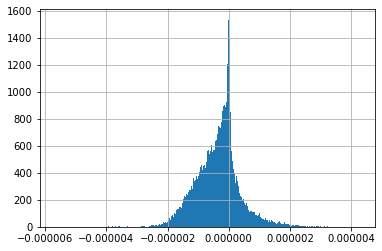

In [30]:
ex1.mean().hist(bins=500)

## Positive Class Pair Saliency, by class

In [31]:
siamese_test_dataset.label_to_indices

{0: array([ 0,  4,  5,  6,  7,  9, 10, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25,
        27, 33, 36, 38, 40, 42, 46, 47, 49, 50, 51, 53, 56]),
 1: array([ 1,  2,  3,  8, 11, 12, 13, 20, 22, 26, 28, 29, 30, 31, 32, 34, 35,
        37, 39, 41, 43, 44, 45, 48, 52, 54, 55])}

In [32]:
classes

array(['Primary Tumor', 'Solid Tissue Normal'], dtype=object)

In [33]:
tumor_pairs = np.where(np.isin(test_pairs[:,0], siamese_test_dataset.label_to_indices[0]) & test_pairs[:,2]==1)[0]
healthy_pairs = np.where(np.isin(test_pairs[:,0], siamese_test_dataset.label_to_indices[1]) & test_pairs[:,2]==1)[0]

In [34]:
tumor_pairs
healthy_pairs

array([ 0,  2,  3,  5,  7,  8,  9, 12, 18, 19, 20, 21, 23, 25, 28])

array([ 1,  4,  6, 10, 11, 13, 14, 15, 16, 17, 22, 24, 26, 27])

In [35]:
test_pairs[tumor_pairs]

array([[ 0, 40,  1],
       [ 4, 19,  1],
       [ 6, 56,  1],
       [10, 15,  1],
       [14, 16,  1],
       [16, 27,  1],
       [18, 47,  1],
       [24,  4,  1],
       [36, 23,  1],
       [38, 46,  1],
       [40,  0,  1],
       [42,  7,  1],
       [46, 24,  1],
       [50, 14,  1],
       [56,  0,  1]])

In [36]:
ex1.iloc[tumor_pairs].mean().nlargest(10)

0
ENSG00000254424.1    0.000005
ENSG00000225110.1    0.000005
ENSG00000207862.1    0.000004
ENSG00000271243.1    0.000004
ENSG00000254526.1    0.000004
ENSG00000174914.1    0.000004
ENSG00000230564.1    0.000004
ENSG00000244571.1    0.000004
ENSG00000272575.4    0.000004
ENSG00000239227.1    0.000004
dtype: float32

In [37]:
ex2.iloc[tumor_pairs].mean().nlargest(10)

0
ENSG00000259094.1    0.000008
ENSG00000212001.2    0.000007
ENSG00000267978.4    0.000007
ENSG00000207130.1    0.000006
ENSG00000238808.1    0.000006
ENSG00000271702.1    0.000006
ENSG00000251172.1    0.000005
ENSG00000275215.1    0.000005
ENSG00000221525.1    0.000005
ENSG00000207492.1    0.000005
dtype: float32